In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cpi
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

/Users/rayan/.pyenv/versions/3.10.0/envs/UtilExpenses/lib/python3.10/site-packages/cpi/__init__.py:42: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [2]:
#cpi.update()

In [3]:
data = pd.read_csv('../datafiles/dispositions_and_opex_and_transmission_and_sales_and_rev.csv')

In [4]:
data.columns

Index(['Unnamed: 0', 'disposition_of_energy', 'energy_losses',
       'internal_use_energy',
       'megawatt_hours_sold_sales_to_ultimate_consumers', 'utility_id_ferc1',
       'report_year', 'load_dispatching',
       'power_production_expenses_hydraulic_power',
       'power_production_expenses_nuclear_power',
       'power_production_expenses_other_power',
       'power_production_expenses_steam_power',
       'administrative_and_general_expenses',
       'administrative_and_general_operation_expense',
       'administrative_and_general_salaries', 'distribution_expenses',
       'distribution_maintenance_expense_electric',
       'maintenance_of_line_transformers', 'maintenance_of_meters',
       'maintenance_of_miscellaneous_distribution_plant',
       'maintenance_of_overhead_lines', 'maintenance_of_station_equipment',
       'maintenance_of_structures_distribution_expense',
       'maintenance_of_underground_lines',
       'maintenance_supervision_and_engineering',
       'distr

# Data Cleaning

* Investigating why transmission length drops in 2021

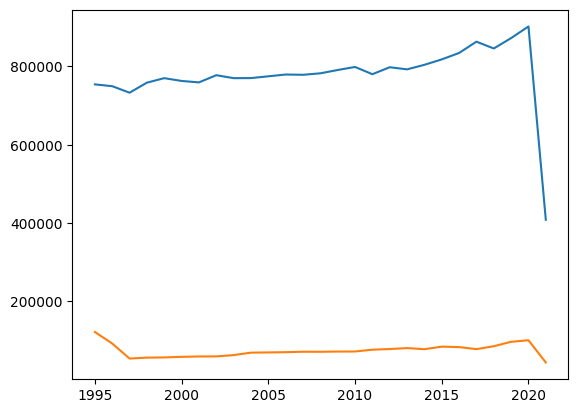

In [5]:
data = data[data.report_year != 1994]
transmission_line_length_miles = data.groupby('report_year')['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
transmission_line_and_structures_length_miles = data.groupby('report_year')['transmission_line_and_structures_length_miles'].agg('sum').reset_index(drop=False)

plt.plot(transmission_line_length_miles.report_year,transmission_line_length_miles.transmission_line_length_miles)
plt.plot(transmission_line_and_structures_length_miles.report_year,transmission_line_and_structures_length_miles.transmission_line_and_structures_length_miles)

* Dropping 1994 and 2021 data - looks wrong
* Dropping extra index column

In [6]:
data = data[data.report_year != 2021]
data.drop(labels='Unnamed: 0',axis='columns',inplace=True)

* Reading in the fuzzy-merged + handcorrected EIA/FERC crosswalk
* Reading back in the EIA plant IDs and merging
* Merging EIA plants with NERC regions, then merging back with FERC crosswalk

In [7]:
eia_ferc = pd.read_csv('../datafiles/eia ferc fuzzy matched manually corrected.csv').dropna(subset='eia')

eia_codes = pd.read_csv('../datafiles/utilities_entity_eia.csv')


merged_eia_codes = pd.merge(eia_ferc,
        eia_codes,
        left_on='eia',
        right_on='utility_name_eia',
        how='left')

ferc_codes = pd.read_csv('../datafiles/utilities_ferc1.csv')


merged_ferc_codes = pd.merge(merged_eia_codes,
                            ferc_codes,
                            left_on='ferc',
                            right_on='utility_name_ferc1',
                            how='right')[['utility_id_eia',
                                         'utility_id_ferc1',
                                         'utility_name_ferc1',
                                         'utility_name_eia']]

In [8]:
states = pd.read_csv('../datafiles/utilities_eia860.csv',usecols=[0,2,5])
states['year_dt'] = pd.to_datetime(states['report_date']).dt.year

In [9]:
nerc = pd.read_excel('../datafiles/StateCodesNERC.xlsx')
merged_eia_interconn_regions = pd.merge(nerc,states,how='right',left_on='Code',right_on='state')[['NERC','State','Code','utility_id_eia']]

In [10]:
ferc_subset_with_nercregion = pd.merge(merged_eia_interconn_regions,
        merged_ferc_codes,
        how='right',
        on='utility_id_eia').dropna(subset='NERC').drop_duplicates()

In [11]:
nerc_interconn_subset_data_disagg = pd.merge(ferc_subset_with_nercregion,
        data,
        how='inner',
        left_on=['utility_id_ferc1'],
        right_on=['utility_id_ferc1'])
nerc_interconn_subset_data_disagg.to_csv('../datafiles/FERC1 data with EIA merge subset and NERC regions.csv')

# Analysis

Producing aggregate annual numbers for key variables

In [12]:
capex_total = data.groupby('report_year')['capex_total'].agg('sum').reset_index(drop=False)
opex_total = data.groupby('report_year')['opex_total'].agg('sum').reset_index(drop=False)
megawatt_hours_sold_sales_to_ultimate_consumers = data.groupby('report_year')['megawatt_hours_sold_sales_to_ultimate_consumers'].agg('sum').reset_index(drop=False)
transmission_line_length_miles = data.groupby('report_year')['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
transmission_expenses = data.groupby('report_year')['transmission_expenses'].agg('sum').reset_index(drop=False)
distribution_expenses = data.groupby('report_year')['distribution_expenses'].agg('sum').reset_index(drop=False)
customer_total = data.groupby('report_year')['avg_customers_per_month'].agg('sum').reset_index(drop=False)

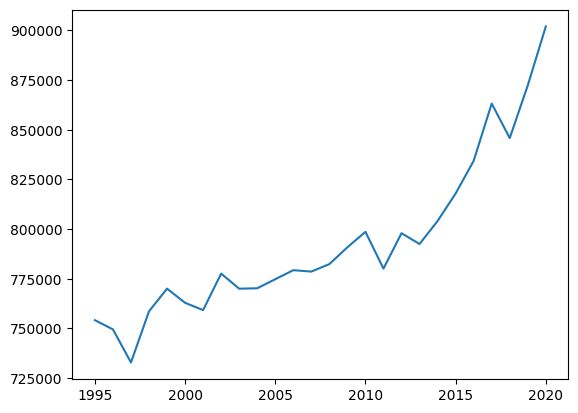

In [13]:
plt.plot(transmission_line_length_miles.report_year,transmission_line_length_miles.transmission_line_length_miles)

Inflation adjusting T&D costs and generating normalized variables

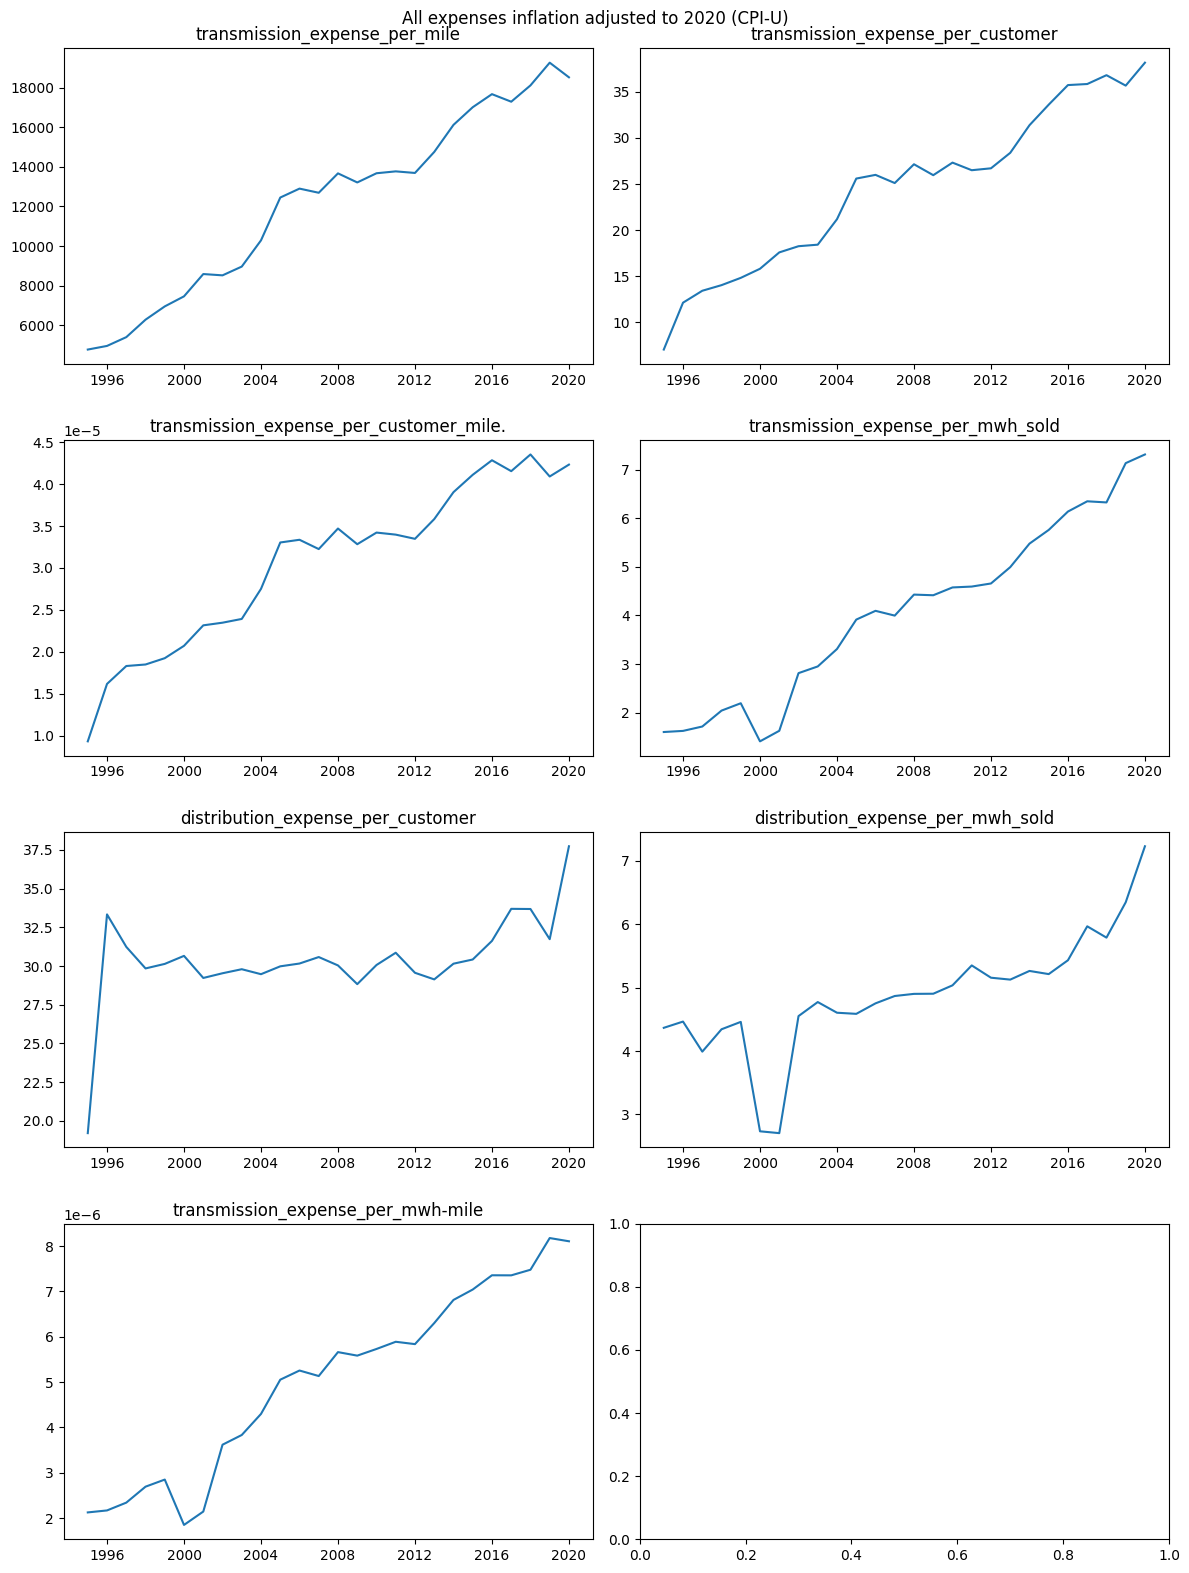

In [14]:
transmission_expenses['year_dt']=pd.to_datetime(transmission_expenses.report_year, format='%Y')
real_transmission_expenses = transmission_expenses.apply(lambda x: cpi.inflate(x["transmission_expenses"], 
                                                                               x["year_dt"],
                                                                              to=pd.to_datetime(2020,format="%Y")),
                                                                               axis=1)
transmission_expenses['inflation-adjusted expenses']= real_transmission_expenses

transmission_expense_per_mile = transmission_expenses['inflation-adjusted expenses']/transmission_line_length_miles['transmission_line_length_miles']
transmission_expense_per_customer = transmission_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
transmission_expense_per_customer_mile = transmission_expenses['inflation-adjusted expenses']/(customer_total['avg_customers_per_month']*transmission_line_length_miles['transmission_line_length_miles'])
transmission_expense_per_mwh_sold = transmission_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']
transmission_expense_per_mwh_mile = transmission_expenses['inflation-adjusted expenses']/(megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']*transmission_line_length_miles['transmission_line_length_miles'])


distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                               x["year_dt"],
                                                                              to=pd.to_datetime(2020,format="%Y")),
                                                                               axis=1)
distribution_expenses['inflation-adjusted expenses']= real_distribution_expenses

distribution_expense_per_customer = distribution_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
distribution_expense_per_mwh_sold = distribution_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']





fig,axs = plt.subplots(nrows=4,ncols=2,figsize=(12,16))
plt.suptitle("All expenses inflation adjusted to 2020 (CPI-U)")
axs[0, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mile)
axs[0, 0].set_title("transmission_expense_per_mile")
axs[0, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_customer)
axs[0, 1].set_title("transmission_expense_per_customer")
axs[1, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_customer_mile)
axs[1, 0].set_title("transmission_expense_per_customer_mile.")
axs[1, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_sold)
axs[1, 1].set_title("transmission_expense_per_mwh_sold")
axs[2, 0].plot(transmission_expenses['year_dt'],distribution_expense_per_customer)
axs[2, 0].set_title("distribution_expense_per_customer")
axs[2, 1].plot(transmission_expenses['year_dt'],distribution_expense_per_mwh_sold)
axs[2, 1].set_title("distribution_expense_per_mwh_sold")

axs[3, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_mile)
axs[3, 0].set_title("transmission_expense_per_mwh-mile")

fig.tight_layout()
plt.show()
fig.savefig('../graphs/inflation adjusted & normalized T&D costs over time.png',bbox_inches='tight',dpi=600)



# Repeating analysis, breaking down transmission costs by U/O

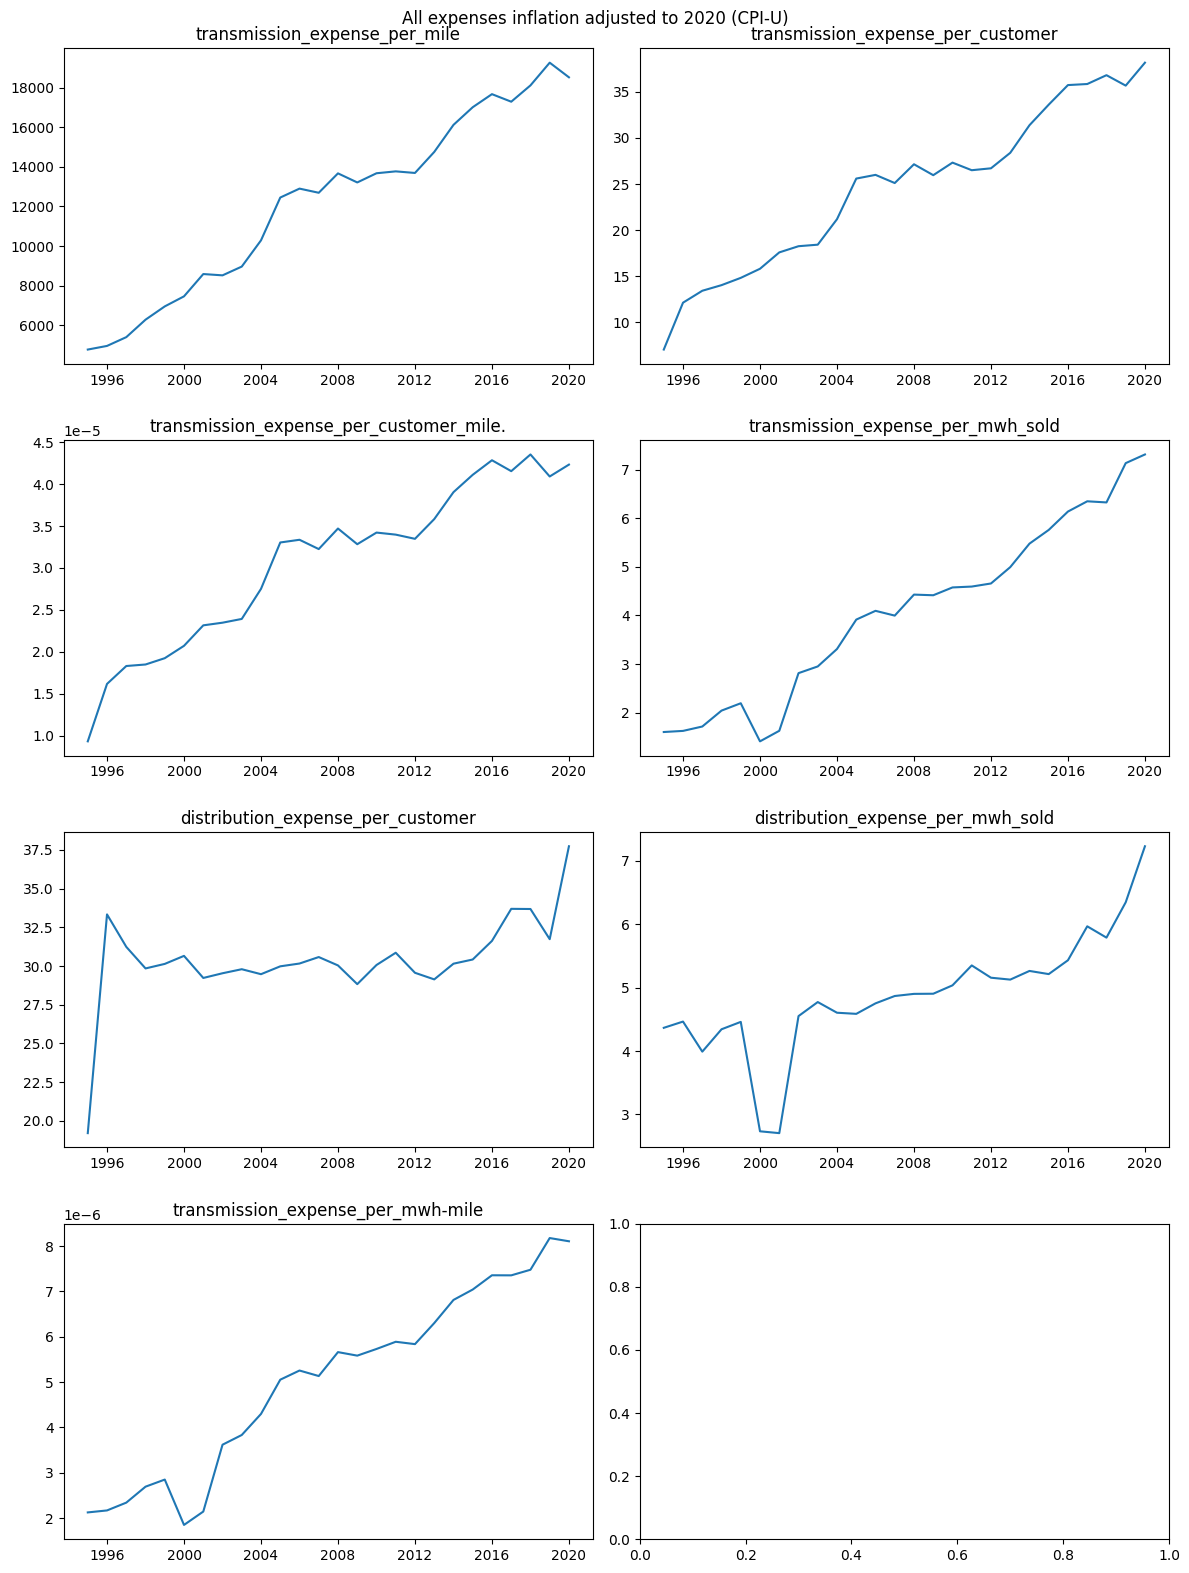

In [15]:
transmission_expenses['year_dt']=pd.to_datetime(transmission_expenses.report_year, format='%Y')
real_transmission_expenses = transmission_expenses.apply(lambda x: cpi.inflate(x["transmission_expenses"], 
                                                                               x["year_dt"],
                                                                              to=pd.to_datetime(2020,format="%Y")),
                                                                               axis=1)
transmission_expenses['inflation-adjusted expenses']= real_transmission_expenses

transmission_expense_per_mile = transmission_expenses['inflation-adjusted expenses']/transmission_line_length_miles['transmission_line_length_miles']
transmission_expense_per_customer = transmission_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
transmission_expense_per_customer_mile = transmission_expenses['inflation-adjusted expenses']/(customer_total['avg_customers_per_month']*transmission_line_length_miles['transmission_line_length_miles'])
transmission_expense_per_mwh_sold = transmission_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']
transmission_expense_per_mwh_mile = transmission_expenses['inflation-adjusted expenses']/(megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']*transmission_line_length_miles['transmission_line_length_miles'])


distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                               x["year_dt"],
                                                                              to=pd.to_datetime(2020,format="%Y")),
                                                                               axis=1)
distribution_expenses['inflation-adjusted expenses']= real_distribution_expenses

distribution_expense_per_customer = distribution_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
distribution_expense_per_mwh_sold = distribution_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']





fig,axs = plt.subplots(nrows=4,ncols=2,figsize=(12,16))
plt.suptitle("All expenses inflation adjusted to 2020 (CPI-U)")
axs[0, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mile)
axs[0, 0].set_title("transmission_expense_per_mile")
axs[0, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_customer)
axs[0, 1].set_title("transmission_expense_per_customer")
axs[1, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_customer_mile)
axs[1, 0].set_title("transmission_expense_per_customer_mile.")
axs[1, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_sold)
axs[1, 1].set_title("transmission_expense_per_mwh_sold")
axs[2, 0].plot(transmission_expenses['year_dt'],distribution_expense_per_customer)
axs[2, 0].set_title("distribution_expense_per_customer")
axs[2, 1].plot(transmission_expenses['year_dt'],distribution_expense_per_mwh_sold)
axs[2, 1].set_title("distribution_expense_per_mwh_sold")

axs[3, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_mile)
axs[3, 0].set_title("transmission_expense_per_mwh-mile")

fig.tight_layout()
plt.show()
fig.savefig('../graphs/inflation adjusted & normalized T&D costs over time.png',bbox_inches='tight',dpi=600)



## Repeating analysis for NERC subregion subset

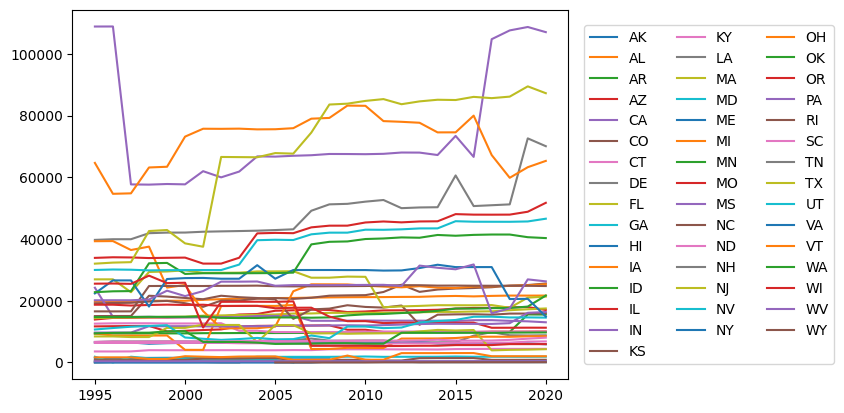

In [16]:
state_trans_len=nerc_interconn_subset_data_disagg.groupby(['Code','report_year']).agg(sum).reset_index()[['report_year','Code','transmission_line_and_structures_length_miles','transmission_line_length_miles']]
state_trans_len['total'] = state_trans_len['transmission_line_and_structures_length_miles']+state_trans_len['transmission_line_length_miles']

for state in state_trans_len['Code'].unique():
    st_data = state_trans_len[state_trans_len['Code']==state]
    plt.plot(st_data['report_year'],st_data['total'],label=state)
plt.legend(loc='right',bbox_to_anchor=(1.55,0.5),ncol=3)

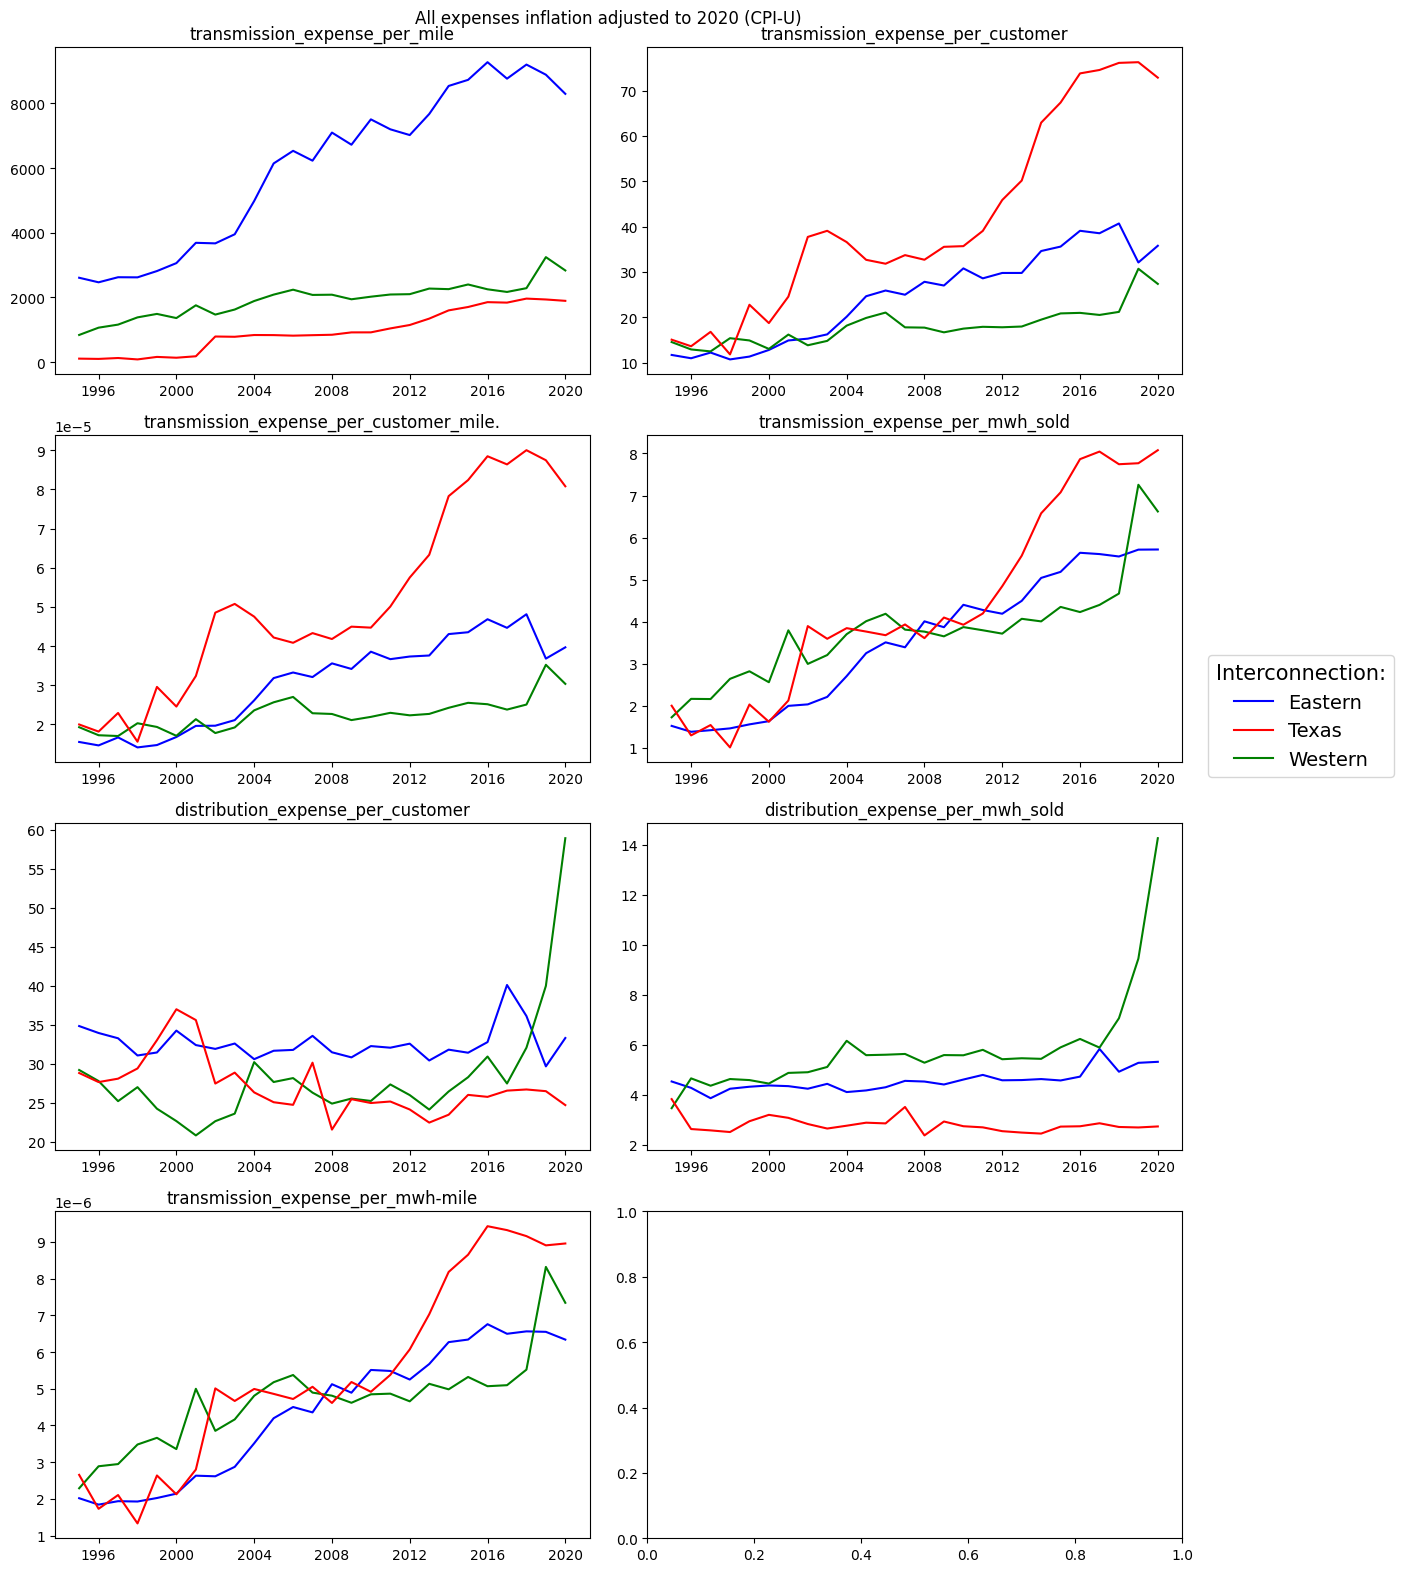

In [17]:
capex_total = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['capex_total'].agg('sum').reset_index(drop=False)
opex_total = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['opex_total'].agg('sum').reset_index(drop=False)
megawatt_hours_sold_sales_to_ultimate_consumers = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['megawatt_hours_sold_sales_to_ultimate_consumers'].agg('sum').reset_index(drop=False)
transmission_line_length_miles = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
transmission_expenses = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['transmission_expenses'].agg('sum').reset_index(drop=False)
distribution_expenses = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['distribution_expenses'].agg('sum').reset_index(drop=False)
customer_total = nerc_interconn_subset_data_disagg.groupby(['report_year','NERC'])['avg_customers_per_month'].agg('sum').reset_index(drop=False)


fig,axs = plt.subplots(nrows=4,ncols=2,figsize=(12,16))
plt.suptitle("All expenses inflation adjusted to 2020 (CPI-U)")

axs[0, 0].set_title("transmission_expense_per_mile")
axs[0, 1].set_title("transmission_expense_per_customer")
axs[1, 0].set_title("transmission_expense_per_customer_mile.")
axs[1, 1].set_title("transmission_expense_per_mwh_sold")
axs[2, 0].set_title("distribution_expense_per_customer")
axs[2, 1].set_title("distribution_expense_per_mwh_sold")

fig.tight_layout()


for nerc_reg,color in {'Eastern':'blue','Western':'green','Texas':'red'}.items():
    
    data_subset = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['NERC']==nerc_reg]
    
    capex_total = data_subset.groupby('report_year')['capex_total'].agg('sum').reset_index(drop=False)
    opex_total = data_subset.groupby('report_year')['opex_total'].agg('sum').reset_index(drop=False)
    megawatt_hours_sold_sales_to_ultimate_consumers = data_subset.groupby('report_year')['megawatt_hours_sold_sales_to_ultimate_consumers'].agg('sum').reset_index(drop=False)
    transmission_line_length_miles = data.groupby('report_year')['transmission_line_length_miles'].agg('sum').reset_index(drop=False)
    transmission_expenses = data_subset.groupby('report_year')['transmission_expenses'].agg('sum').reset_index(drop=False)
    distribution_expenses = data_subset.groupby('report_year')['distribution_expenses'].agg('sum').reset_index(drop=False)
    customer_total = data_subset.groupby('report_year')['avg_customers_per_month'].agg('sum').reset_index(drop=False)
    

    transmission_expenses['year_dt']=pd.to_datetime(transmission_expenses.report_year, format='%Y')
    real_transmission_expenses = transmission_expenses.apply(lambda x: cpi.inflate(x["transmission_expenses"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                                                   axis=1)
    transmission_expenses['inflation-adjusted expenses']= real_transmission_expenses

    transmission_expense_per_mile = transmission_expenses['inflation-adjusted expenses']/transmission_line_length_miles['transmission_line_length_miles']
    transmission_expense_per_customer = transmission_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
    transmission_expense_per_customer_mile = transmission_expenses['inflation-adjusted expenses']/(customer_total['avg_customers_per_month']*transmission_line_length_miles['transmission_line_length_miles'])
    transmission_expense_per_mwh_sold = transmission_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']
    transmission_expense_per_mwh_mile = transmission_expenses['inflation-adjusted expenses']/(megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']*transmission_line_length_miles['transmission_line_length_miles'])





    distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
    real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                                                   axis=1)
    distribution_expenses['inflation-adjusted expenses']= real_distribution_expenses

    distribution_expense_per_customer = distribution_expenses['inflation-adjusted expenses']/customer_total['avg_customers_per_month']
    distribution_expense_per_mwh_sold = distribution_expenses['inflation-adjusted expenses']/megawatt_hours_sold_sales_to_ultimate_consumers['megawatt_hours_sold_sales_to_ultimate_consumers']

    axs[0, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mile,label=nerc_reg,color=color)
    axs[0, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_customer,label=nerc_reg,color=color)
    axs[1, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_customer_mile,label=nerc_reg,color=color)
    axs[1, 1].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_sold,label=nerc_reg,color=color)
    axs[2, 0].plot(transmission_expenses['year_dt'],distribution_expense_per_customer,label=nerc_reg,color=color)
    axs[2, 1].plot(transmission_expenses['year_dt'],distribution_expense_per_mwh_sold,label=nerc_reg,color=color)
    axs[3, 0].plot(transmission_expenses['year_dt'],transmission_expense_per_mwh_mile,label=nerc_reg,color=color)
    axs[3, 0].set_title("transmission_expense_per_mwh-mile")



custom_lines = [Line2D([0], [0], color='blue'),
                Line2D([0], [0], color='red'),
                Line2D([0], [0], color='green')
               ]
fig.legend(custom_lines, ['Eastern', 'Texas', 'Western'], 
           loc=(0,0),
           bbox_to_anchor=(1,0.5),
           fontsize=14,
          title='Interconnection:',
           title_fontsize=15
          )
plt.show()

fig.savefig('../graphs/inflation adjusted & normalized T&D costs over time - nerc subset.png',bbox_inches='tight',dpi=600)




## Repeating for Western Interconn distribution expenses

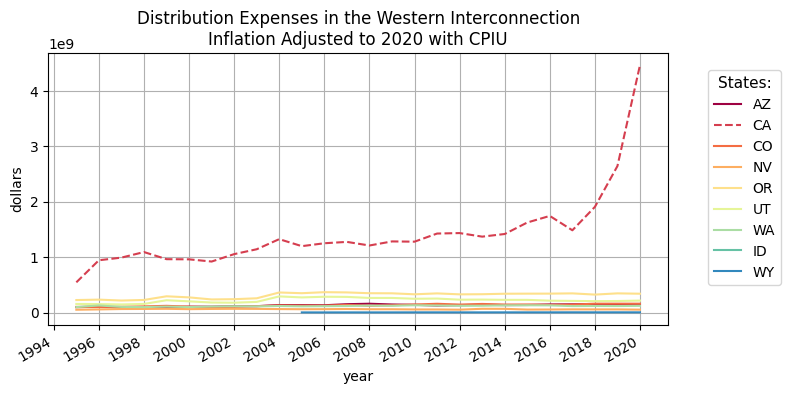

In [18]:
western_state_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['NERC']=='Western'].groupby(['report_year','Code']).agg(sum).reset_index()
states = western_state_sum['Code'].unique()
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
linestyles = ['-','--','-','-','-','-','-','-','-']
handles=[]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))

for idx,state in enumerate(states):
    color = colors[idx]
    ls=linestyles[idx]
    state_data = western_state_sum[western_state_sum['Code']==state]
    
    
    distribution_expenses = state_data.groupby('report_year')['distribution_expenses'].agg('sum').reset_index(drop=False)
    distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
    real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                            axis=1)

    
    ax.plot(distribution_expenses['year_dt'],real_distribution_expenses,label=state,color=color,ls=ls)
    handles.append(Line2D([0], [0], color=color,ls=ls))
    
fig.legend(handles, states, 
           loc=(0,0),
           bbox_to_anchor=(0.95,0.3),
           fontsize=10,
          title='States:',
           title_fontsize=11
          )

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()


ax.set_title("Distribution Expenses in the Western Interconnection\nInflation Adjusted to 2020 with CPIU")
plt.xlabel('year')
plt.ylabel('dollars')
plt.grid(True)
plt.show()

fig.savefig("../graphs/Distribution Expenses in the Western Interconnection.png",dpi=600,bbox_inches='tight')

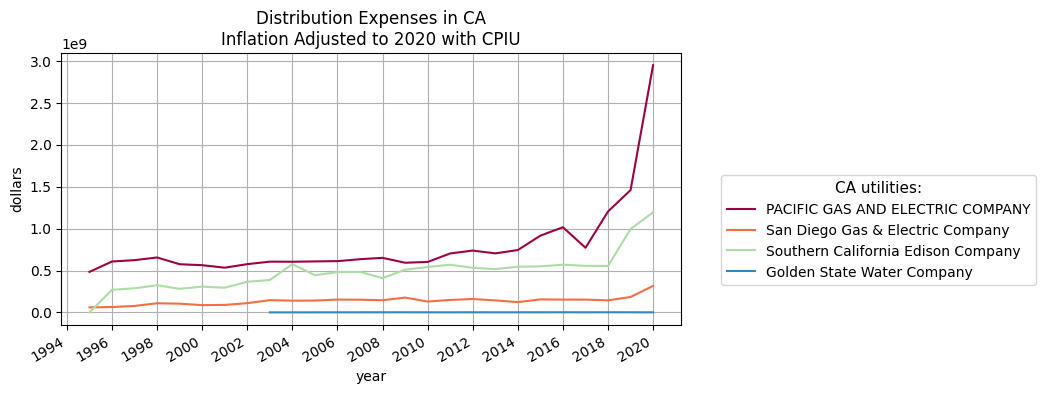

In [19]:
ca_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['Code']=='CA'].groupby(['report_year','utility_name_ferc1']).agg(sum).reset_index()
utils = ca_sum['utility_name_ferc1'].unique()
colors = ['#9e0142','#f46d43','#abdda4','#3288bd']
linestyles = ['-','-','-','-']
handles=[]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))

for idx,util in enumerate(utils):
    color = colors[idx]
    ls=linestyles[idx]
    util_data = ca_sum[ca_sum['utility_name_ferc1']==util]
    
    distribution_expenses = util_data.groupby('report_year')['distribution_expenses'].agg('sum').reset_index(drop=False)
    distribution_expenses['year_dt']=pd.to_datetime(distribution_expenses.report_year, format='%Y')
    real_distribution_expenses = distribution_expenses.apply(lambda x: cpi.inflate(x["distribution_expenses"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                            axis=1)

    
    ax.plot(distribution_expenses['year_dt'],real_distribution_expenses,label=util,color=color,ls=ls)
    handles.append(Line2D([0], [0], color=color,ls=ls))
    
fig.legend(handles, utils, 
           loc=(0,0),
           bbox_to_anchor=(0.95,0.3),
           fontsize=10,
          title='CA utilities:',
           title_fontsize=11
          )

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()


ax.set_title("Distribution Expenses in CA\nInflation Adjusted to 2020 with CPIU")
plt.xlabel('year')
plt.ylabel('dollars')
plt.grid(True)
plt.show()

fig.savefig("../graphs/Distribution Expenses in CA.png",dpi=600,bbox_inches='tight')

## Repeating for PG&E distr expense types

In [20]:
pge_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['utility_name_ferc1']=='PACIFIC GAS AND ELECTRIC COMPANY'].groupby('report_year').sum().reset_index()

pge_sum['year_dt']=pd.to_datetime(pge_sum.report_year, format='%Y')
pge_sum['real_distribution_maintenance_expense_electric'] = pge_sum.apply(lambda x: cpi.inflate(x["distribution_maintenance_expense_electric"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                            axis=1)
pge_sum['real_distribution_operation_expenses_electric'] = pge_sum.apply(lambda x: cpi.inflate(x["distribution_operation_expenses_electric"], 
                                                                                   x["year_dt"],
                                                                                  to=pd.to_datetime(2020,format="%Y")),
                                                            axis=1)


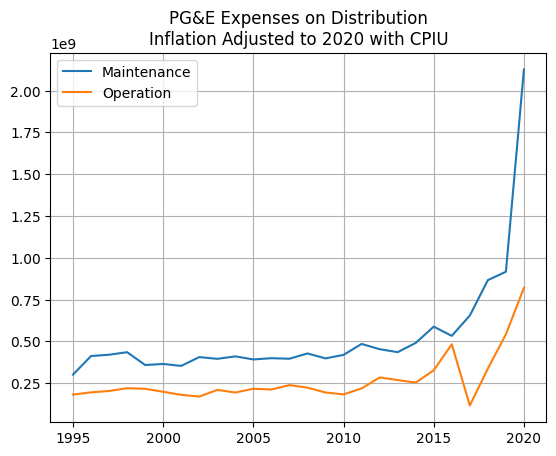

In [21]:
plt.plot(pge_sum['report_year'],pge_sum['real_distribution_maintenance_expense_electric'],label='Maintenance')
plt.plot(pge_sum['report_year'],pge_sum['real_distribution_operation_expenses_electric'],label='Operation')
plt.legend()
plt.grid(True)
plt.title("PG&E Expenses on Distribution\nInflation Adjusted to 2020 with CPIU")
plt.savefig('../graphs/PG&E Expenses on Distribution.png')

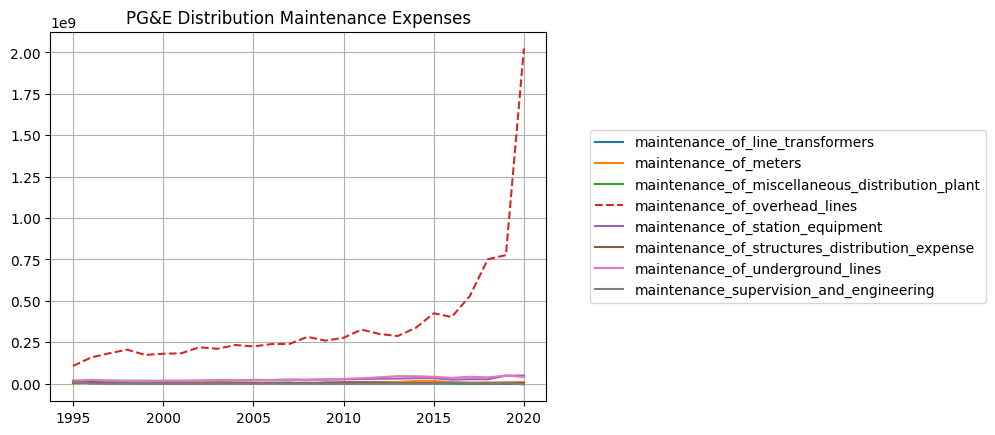

In [22]:
maintenance_distr_components=['maintenance_of_line_transformers',
                                                                                'maintenance_of_meters',
                                                                                'maintenance_of_miscellaneous_distribution_plant',
                                                                                'maintenance_of_overhead_lines',
                                                                                'maintenance_of_station_equipment',
                                                                                'maintenance_of_structures_distribution_expense',
                                                                                'maintenance_of_underground_lines',
                                                                                'maintenance_supervision_and_engineering']

linestyles=['-','-','-','--','-','-','-','-']
for idx,component in enumerate(maintenance_distr_components):
    plt.plot(pge_sum['report_year'],pge_sum[component],label=component,ls=linestyles[idx])
plt.legend(loc='right',bbox_to_anchor=(1.9,0.5))
plt.grid(True)
plt.title('PG&E Distribution Maintenance Expenses')
plt.savefig('../graphs/PG&E Distribution Maintenance Expenses.png',dpi=600,bbox_inches='tight')

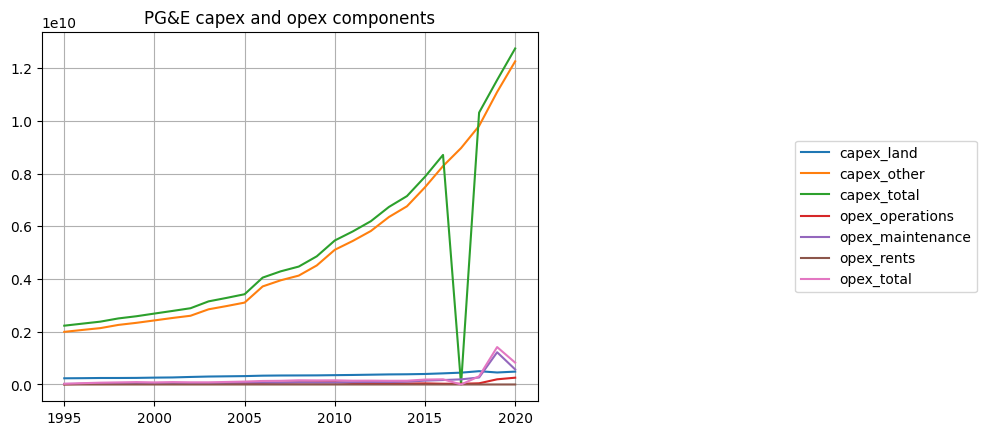

In [23]:
capop_components=['capex_land', 'capex_other', 'capex_total',
       'opex_operations', 'opex_maintenance', 'opex_rents', 'opex_total']
linestyles=['-','-','-','-','-','-','-']

for idx,component in enumerate(capop_components):
    plt.plot(pge_sum['report_year'],pge_sum[component],label=component,ls=linestyles[idx])
plt.legend(loc='right',bbox_to_anchor=(1.9,0.5))
plt.grid(True)
plt.title('PG&E capex and opex components')
plt.savefig('../graphs/PG&E capex and opex components.png',dpi=600,bbox_inches='tight')

# SCE Special Investigation

In [24]:
sce_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['utility_name_ferc1']=='Southern California Edison Company']
sce_sum.columns

Index(['NERC', 'State', 'Code', 'utility_id_eia', 'utility_id_ferc1',
       'utility_name_ferc1', 'utility_name_eia', 'disposition_of_energy',
       'energy_losses', 'internal_use_energy',
       'megawatt_hours_sold_sales_to_ultimate_consumers', 'report_year',
       'load_dispatching', 'power_production_expenses_hydraulic_power',
       'power_production_expenses_nuclear_power',
       'power_production_expenses_other_power',
       'power_production_expenses_steam_power',
       'administrative_and_general_expenses',
       'administrative_and_general_operation_expense',
       'administrative_and_general_salaries', 'distribution_expenses',
       'distribution_maintenance_expense_electric',
       'maintenance_of_line_transformers', 'maintenance_of_meters',
       'maintenance_of_miscellaneous_distribution_plant',
       'maintenance_of_overhead_lines', 'maintenance_of_station_equipment',
       'maintenance_of_structures_distribution_expense',
       'maintenance_of_underground_

## Revenue breakdown

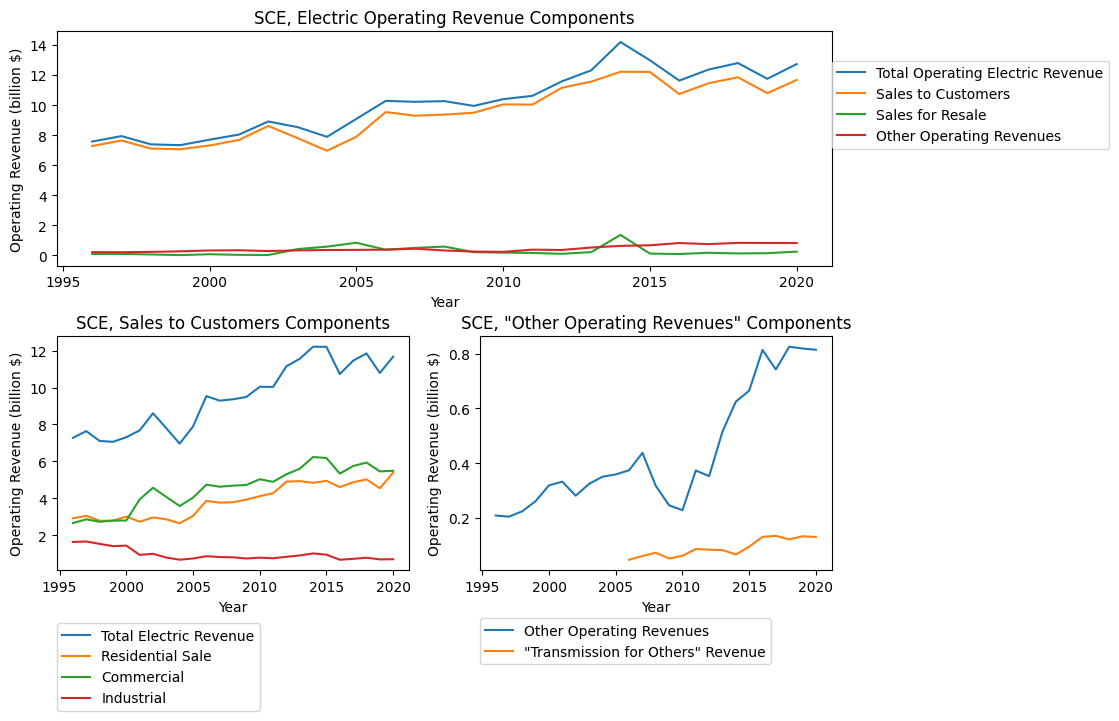

In [25]:
# Create layout
layout = [
    ["A", "A"],
    ["B", "C"]
]

fig, axd = plt.subplot_mosaic(layout, figsize=(10,7))


axd['A'].plot(sce_sum['report_year'],sce_sum['electric_operating_revenues']/1e9,label='Total Operating Electric Revenue')

axd['A'].plot(sce_sum['report_year'],sce_sum['sales_to_ultimate_consumers']/1e9,label='Sales to Customers')

axd['A'].plot(sce_sum['report_year'],sce_sum['sales_for_resale']/1e9,label='Sales for Resale')

axd['A'].plot(sce_sum['report_year'],sce_sum['other_operating_revenues']/1e9,label='Other Operating Revenues')

axd['A'].set_xlabel('Year')

axd['A'].set_ylabel('Operating Revenue (billion $)')
axd['A'].set_title('SCE, Electric Operating Revenue Components')

axd['A'].legend(loc=(1,1),bbox_to_anchor=(1,0.5))



axd['B'].set_xlabel('Year')
axd['B'].set_ylabel('Operating Revenue (billion $)')
axd['B'].set_title('SCE, Sales to Customers Components')


axd['B'].plot(sce_sum['report_year'],sce_sum['sales_to_ultimate_consumers']/1e9,label='Total Electric Revenue')
axd['B'].plot(sce_sum['report_year'],sce_sum['residential_sales']/1e9,label='Residential Sale')
axd['B'].plot(sce_sum['report_year'],sce_sum['small_or_commercial']/1e9,label='Commercial')
axd['B'].plot(sce_sum['report_year'],sce_sum['large_or_industrial']/1e9,label='Industrial')

axd['B'].legend(loc=(1,1),bbox_to_anchor=(0,-0.6))



axd['C'].set_xlabel('Year')

axd['C'].set_ylabel('Operating Revenue (billion $)')
axd['C'].set_title('SCE, \"Other Operating Revenues\" Components')

axd['C'].plot(sce_sum['report_year'],sce_sum['other_operating_revenues']/1e9,label='Other Operating Revenues')

axd['C'].plot(sce_sum['report_year'],sce_sum['revenues_from_transmission_of_electricity_of_others']/1e9,label='\"Transmission for Others\" Revenue')

axd['C'].legend(loc=(1,1),bbox_to_anchor=(0,-0.4))


plt.subplots_adjust(hspace=0.3)

fig.savefig('../graphs/SCE Revenue Breakdown.png',dpi=600,bbox_inches='tight')

## Power expenses breakdown

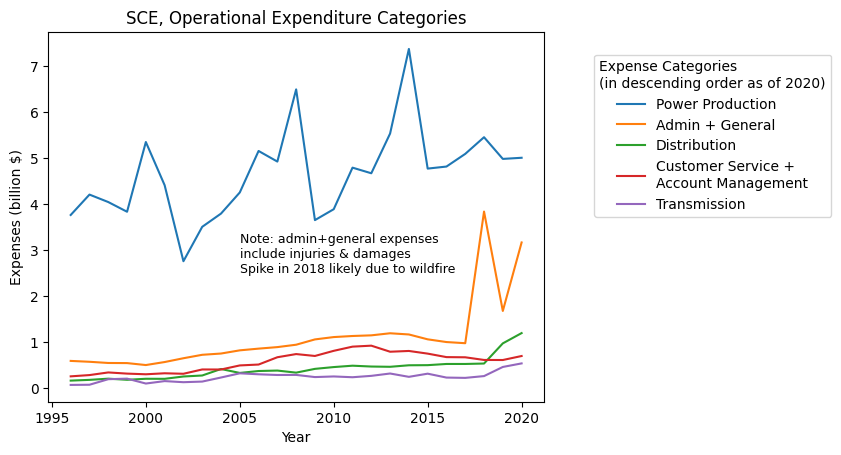

In [26]:
plt.plot(sce_sum['report_year'],sce_sum['power_production_expenses']/1e9,label='Power Production')
plt.plot(sce_sum['report_year'],sce_sum['administrative_and_general_expenses']/1e9,label='Admin + General')
plt.plot(sce_sum['report_year'],sce_sum['distribution_expenses']/1e9,label='Distribution')
plt.plot(sce_sum['report_year'],(sce_sum['customer_account_expenses']+sce_sum['customer_service_and_information_expenses'])/1e9,label='Customer Service +\nAccount Management')
plt.plot(sce_sum['report_year'],sce_sum['transmission_expenses']/1e9,label='Transmission')
#plt.plot(sce_sum['report_year'],sce_sum['customer_service_and_information_expenses']/1e9,label='Customer Service')
#plt.plot(sce_sum['report_year'],sce_sum['sales_expenses']/1e9,label='Sales')
#plt.plot(sce_sum['report_year'],sce_sum['regional_market_expenses']/1e9,label='Regional Market Expenses')
plt.title("SCE, Operational Expenditure Categories")
plt.ylabel("Expenses (billion $)")
plt.xlabel("Year")
plt.text(2005,2.5,'Note: admin+general expenses\ninclude injuries & damages\nSpike in 2018 likely due to wildfire',fontsize=9)

plt.legend(title='Expense Categories\n(in descending order as of 2020)',loc=(1,1),bbox_to_anchor=(1.1,0.5))

plt.savefig('SCE Expense Categories.png',dpi=600,bbox_inches='tight')


Text(0.5, 1.0, 'SCE, Power Production Expenditure Components\n(Note y axis log scale)')

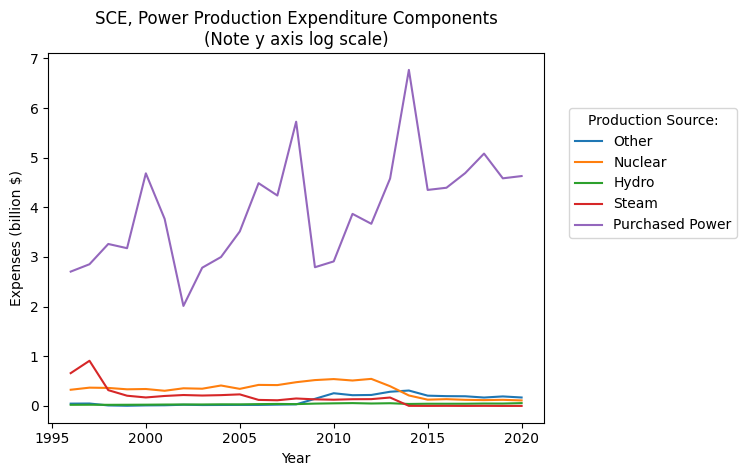

In [27]:
plt.plot(sce_sum['report_year'],sce_sum['power_production_expenses_other_power']/1e9,label='Other')
plt.plot(sce_sum['report_year'],sce_sum['power_production_expenses_nuclear_power']/1e9,label='Nuclear')
plt.plot(sce_sum['report_year'],sce_sum['power_production_expenses_hydraulic_power']/1e9,label='Hydro')
plt.plot(sce_sum['report_year'],sce_sum['power_production_expenses_steam_power']/1e9,label='Steam')

plt.plot(sce_sum['report_year'],sce_sum['purchased_power']/1e9,label='Purchased Power')
plt.legend(title='Production Source:',loc=(1,1),bbox_to_anchor=(1.05,0.5))
plt.ylabel("Expenses (billion $)")
#plt.yscale('log')
plt.xlabel("Year")
plt.title("SCE, Power Production Expenditure Components\n(Note y axis log scale)")
#plt.savefig('SCE Power Production Expenditure Components.png',dpi=600,bbox_inches='tight')


In [28]:
sce_sum.to_csv("../datafiles/SCE form1data.csv")